# Predicting House Sale Prices

In [181]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [182]:
# Importing data
housing = pd.read_table('AmesHousing.tsv', sep='\t')
housing.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


# Feature Transformation:

## Leakage
- Columns that would not be available if you are trying to predict the value of homes not yet sold are:
    - 'Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition',
    - and 'SalePrice' which is what we're trying to predict
    
## Relevance
- Columns such as 'Order' and 'PID' are not useful for machine learning because they do not contain data relevant to the home

## Data Types
- Data that was misclassified as objects was changed to numerical
- The remaining object data was changed to categorical data
- Any numerical data that was missing less than 5% of the values was replaced with the median of the column


In [183]:
def transform_features(df, cat_cutoff):
    train_df = df.copy()
    # Dropping leakage columns and unuseful columns 
    leakage_cols = ['Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition']
    train_df.drop(leakage_cols,  axis = 1, inplace=True )
    # Determining the number of null values in each column
    null_values = train_df.isnull().sum()
    # Creating a cutoff point of less than 5% null values
    cut_off = 0.05 * train_df.shape[0]
    # Subsetting data to only include values with less than cut_off
    train_df = train_df[null_values[null_values < cut_off].index]
    numeric_cols = ['Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
    for col in numeric_cols:
        try:
            train_df[col] = pd.to_numeric(train_df[col])
        except:
            pass
    # Getting columns with the type object
    obj_columns = train_df.select_dtypes(include = ['object']).columns
    # Converting object columns to category 
    for col in obj_columns:
        train_df[col] = train_df[col].astype('category')
    # Limiting the number of unique values that a categorical value can have to prevent
    # adding too many dummy columns 
    unique_cat_values = train_df.select_dtypes(include = ['category']).nunique()
    # Assigning an arbitrary cut off value
    keep_cat = unique_cat_values[unique_cat_values<cat_cutoff].index
    # Getting dummy columns for categorical data
    dum_cols = pd.get_dummies(train_df[keep_cat])
    # Adding dummy columns and dropping non-numerical columns
    train_df = pd.concat([train_df.drop(unique_cat_values.index, axis=1), dum_cols], axis=1)
    # Filling remaining missing values with the most popular value in the column
    num_cols= train_df.select_dtypes(include=['int', 'float']).columns
    for col in num_cols:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
    # Creating a new feature to house time before the home was remodeled
    train_df['years_until_remod'] = train_df['Year Remod/Add'] - train_df['Year Built']
    return train_df

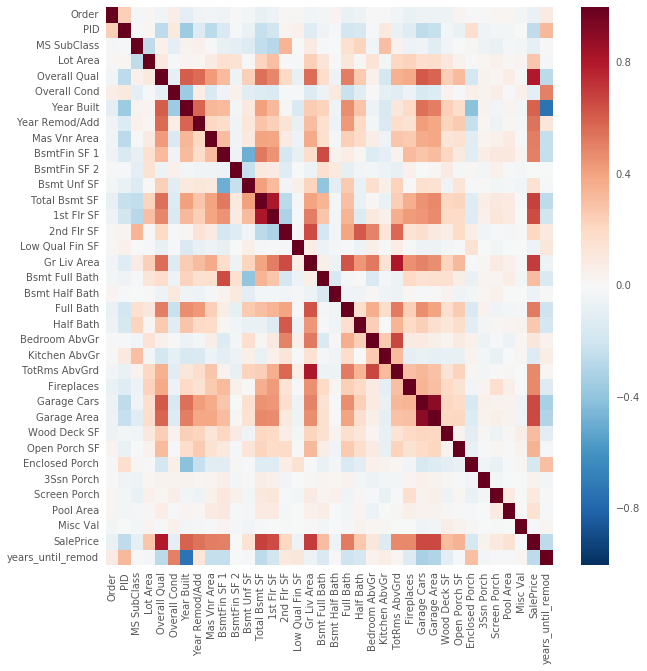

In [184]:
# Looking at numerical features correlation
data = transform_features(housing[:1490], 10).select_dtypes(['float','int'])

corr_data = data.corr()
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(corr_data)
plt.show()

## Strongly Correlated Features:

1. Garage Area and Garage Cars
2. Total Basement SF and 1st Flr SF
2. TotRms AbvGrd and Gr Liv Area

One of these features will be dropped to avoid duplicate information 

In [185]:
def select_features(df, corr_cutoff):
    df = df.copy()
    #Dropping strongly correlated columsn to prevent redundant information
    str_corr_columns = ['Garage Cars', 'TotRms AbvGrd', '1st Flr SF']
    df.drop(str_corr_columns, axis=1, inplace=True)
    #Getting rid of columns not relevant to machine learning
    not_relevant_cols = ['PID', 'Order']
    df.drop(not_relevant_cols, axis=1, inplace=True)
    # Selecting highly correlated columns to SalePrice 
    data = df.select_dtypes(['float','int', 'uint8'])
    # Getting the correlation matrix
    corr_data = data.corr()
    # Looking at correlation to SalePrice
    sale_corr = abs(corr_data['SalePrice'])
    # Keeping values with a correlation greater than the set value
    num_values_keep = sale_corr[sale_corr > corr_cutoff].index
    # Subsetting the dataframe
    df_final = df[num_values_keep]
    return df_final

In [186]:
def train_and_test(df, cat_cutoff, corr_cutoff):
    df = transform_features(df, cat_cutoff)
    df = select_features(df, corr_cutoff)
    # Dividing data into train and test sets
    cut_off = int(len(df)/2)
    train = df.iloc[:cut_off]
    test = df.iloc[cut_off:]
    # Selecting features
    train_X = train.drop('SalePrice', axis=1)  
    train_y = train['SalePrice']
    test_X = test.drop('SalePrice', axis=1)
    test_y = test['SalePrice']
    # Creating model 
    lr = LinearRegression()
    lr.fit(train_X, train_y)
    # Testing the model
    train_predictions = lr.predict(train_X)
    test_predictions = lr.predict(test_X)
    train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions)) 
    test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
    return train_rmse, test_rmse


In [187]:
corr_cutoffs = np.linspace(.2, .7, 5)
cat_cutoffs = np.linspace(5, 20, 5)

rsmes_dict = {}
for corr in corr_cutoffs:
    rsmes = {}
    for cat in cat_cutoffs:
        rsmes[cat] = train_and_test(housing, int(cat), round(corr,1))
    rsmes_dict[corr] = rsmes

##  Feature Selection Optimization

Arbitrary cut off points were left in each function.  To determine what correlation value should be the cut off point for all of the binary and numerica columns, and what the limit for categorical values hould be, iterating through a possible range of values yields the following dictionary. 

rsmes_dict

## Cross Validation Scoring

Selecting the highest performing cut off values cross validation was performed using the mean square error as the measure for the model. 

In [197]:
def train_and_test_cv(df, cat_cutoff, corr_cutoff, k):
    df = transform_features(df, cat_cutoff)
    df = select_features(df, corr_cutoff)
    # Creating model 
    lr = LinearRegression()
    # Using the cross validation scoring method
    scores = cross_val_score(lr, df.drop('SalePrice', axis=1), df['SalePrice'], scoring= 'neg_mean_squared_error', cv=k)
    return np.sqrt(abs(scores))

In [196]:
score_vals = train_and_test_cv(housing, 9, 0.35, 6)
print("The average score is: {}".format(int(np.mean(score_vals))))

The average score is: 31164


## Scoring Metric

After tweaking the parameter a bit more around the final scoring values was $31,164, which can be interpreted as the dollar amount the prediction is expected to be off the actual value.  